In [2]:
import numpy as np
import pandas as pd
import keras
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import stats
import keras_metrics as km
from keras.models import Model
from keras.models import load_model
from keras import backend, layers, models, utils
from keras.layers import Conv1D,MaxPooling1D,Dense,Dropout,Flatten,GlobalAveragePooling1D
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Reshape
from keras.layers import Dense, Activation
from keras.optimizers import RMSprop
from sklearn import preprocessing
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")

In [166]:
df = pd.read_csv('fossil1_filtered.csv')

In [167]:
#applying max-min normalization 
min_max_scaler = preprocessing.MinMaxScaler()
df_x = min_max_scaler.fit_transform(df[['x']])
df_y = min_max_scaler.fit_transform(df[['y']])
df_z = min_max_scaler.fit_transform(df[['z']])

In [168]:
def segmentation(df, time, stride, tag):

    # 3 features: x, y, z acceleration
    features = 3

    seg = []
    labels = []
    for i in range(0, len(df) - time, stride):
        x_seg = df_x[i: i + time]
        y_seg = df_y[i: i + time]
        z_seg = df_z[i: i + time]
        
        # find the commonly used label in each segment
        label = stats.mode(df[tag][i: i + time])[0][0]
        
        seg.append([x_seg, y_seg, z_seg])
        labels.append(label)

    # reshape the segments to a size of 'time'*'features' matrix, regardless of how many rows there are
    reshape_seg = np.asarray(seg, dtype= np.float32).reshape(-1, time, features)
    labels = np.array(labels)

    return reshape_seg, labels

x, y = segmentation(df,100,100,'label')

In [169]:
#convert the labels into one-hot encoding
encoder = preprocessing.LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_onehot = np_utils.to_categorical(y_encoded)

In [170]:
X_train, X_test, y_train, y_test = train_test_split(x, y_onehot, test_size = 0.4, random_state = 42)

In [171]:
#build an 1d CNN
model = Sequential()
model.add(Conv1D(64, 2, activation='relu', input_shape=(100, 3)))
model.add(Conv1D(64, 2, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))
model.add(Conv1D(256, 2, activation='relu'))
model.add(Conv1D(256, 2, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='softmax'))
model.add(Dense(2, activation='softmax'))
print(model.summary())
model.compile(loss='binary_crossentropy',
                 optimizer='adam', metrics=['accuracy',km.binary_precision(), km.binary_recall()])

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_64 (Conv1D)           (None, 99, 64)            448       
_________________________________________________________________
conv1d_65 (Conv1D)           (None, 98, 64)            8256      
_________________________________________________________________
dropout_29 (Dropout)         (None, 98, 64)            0         
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 49, 64)            0         
_________________________________________________________________
conv1d_66 (Conv1D)           (None, 48, 256)           33024     
_________________________________________________________________
conv1d_67 (Conv1D)           (None, 47, 256)           131328    
_________________________________________________________________
dropout_30 (Dropout)         (None, 47, 256)         

In [172]:
history = model.fit(X_train,
                    y_train,
                    batch_size=40,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    )

Epoch 1/50
2/2 [==============================] - 0s 110ms/step - loss: 0.6929 - accuracy: 0.5593 - precision: 0.5672 - recall: 1.0000 - val_loss: 0.6946 - val_accuracy: 0.4000 - val_precision: 0.4000 - val_recall: 1.0000
Epoch 2/50
2/2 [==============================] - 0s 21ms/step - loss: 0.6919 - accuracy: 0.5593 - precision: 0.5547 - recall: 1.0000 - val_loss: 0.6957 - val_accuracy: 0.4000 - val_precision: 0.4000 - val_recall: 1.0000
Epoch 3/50
2/2 [==============================] - 0s 22ms/step - loss: 0.6905 - accuracy: 0.5593 - precision: 0.5297 - recall: 1.0000 - val_loss: 0.6970 - val_accuracy: 0.4000 - val_precision: 0.4000 - val_recall: 1.0000
Epoch 4/50
2/2 [==============================] - 0s 19ms/step - loss: 0.6882 - accuracy: 0.5593 - precision: 0.5297 - recall: 1.0000 - val_loss: 0.6989 - val_accuracy: 0.4000 - val_precision: 0.4000 - val_recall: 1.0000
Epoch 5/50
2/2 [==============================] - 0s 24ms/step - loss: 0.6873 - accuracy: 0.5593 - precision: 0.579

Epoch 38/50
2/2 [==============================] - 0s 21ms/step - loss: 0.5299 - accuracy: 0.9322 - precision: 1.0000 - recall: 0.8939 - val_loss: 0.5912 - val_accuracy: 0.8000 - val_precision: 1.0000 - val_recall: 0.5000
Epoch 39/50
2/2 [==============================] - 0s 20ms/step - loss: 0.5325 - accuracy: 0.9153 - precision: 1.0000 - recall: 0.8190 - val_loss: 0.5903 - val_accuracy: 0.8000 - val_precision: 1.0000 - val_recall: 0.5000
Epoch 40/50
2/2 [==============================] - 0s 20ms/step - loss: 0.5317 - accuracy: 0.9153 - precision: 1.0000 - recall: 0.8617 - val_loss: 0.5892 - val_accuracy: 0.8000 - val_precision: 1.0000 - val_recall: 0.5000
Epoch 41/50
2/2 [==============================] - 0s 20ms/step - loss: 0.5248 - accuracy: 0.9322 - precision: 1.0000 - recall: 0.8524 - val_loss: 0.5822 - val_accuracy: 0.8250 - val_precision: 1.0000 - val_recall: 0.5625
Epoch 42/50
2/2 [==============================] - 0s 20ms/step - loss: 0.5083 - accuracy: 0.9661 - precision: 1

In [175]:
model.save('fossil1.h5')

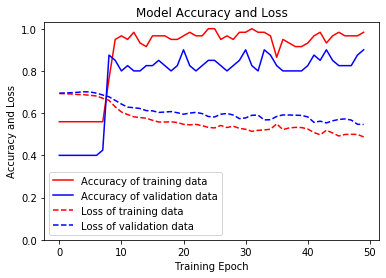

In [176]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [178]:
#load model and print confusion matrix
model = load_model('fossil1.h5')

y_pred_train = model.predict(X_train)
max_y_pred_train = np.rint(y_pred_train)
print(classification_report(y_train, max_y_pred_train))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        33
           1       0.96      1.00      0.98        26

   micro avg       0.98      0.98      0.98        59
   macro avg       0.98      0.98      0.98        59
weighted avg       0.98      0.98      0.98        59
 samples avg       0.98      0.98      0.98        59

